# **Retrieval Augmented Generation (RAG) 애플리케이션 구축: Part 1**

### 자신만의 문서를 활용하여 응답을 생성하는 애플리케이션 구축

- **Part 1**: RAG 개념을 소개하고, 최소한의 구현 방법을 설명합니다.  
- **Part 2** 기존 구현을 확장하여 대화형 상호작용과 다단계 검색 프로세스를 처리할 수 있도록 개선합니다.
---

## 전형적인 **RAG 애플리케이션**

두 가지 주요 구성 요소로 이루어져 있습니다:  

1. **인덱싱(Indexing)**: 데이터 소스를 수집하고 인덱싱하는 파이프라인입니다. *일반적으로 오프라인에서 수행됩니다.*  
2. **검색 및 생성(Retrieval and Generation)**: 실행 시간에 사용자 쿼리를 받아 인덱스에서 관련 데이터를 검색한 후, 모델에 전달하여 답변을 생성합니다.  

---

### **인덱싱 단계**  
일반적인 데이터 인덱싱 과정은 다음과 같습니다:  

1. **로드(Load)**  
   - 먼저 데이터를 불러와야 합니다. 이는 문서 로더(Document Loaders)를 사용하여 수행됩니다.  

2. **분할(Split)**  
   - 텍스트 분할기(Text Splitters)를 사용해 큰 `문서(Document)`를 작은 청크(chunk)로 나눕니다.  
   - 이렇게 하면 검색이 더 효율적이며, 모델의 제한된 컨텍스트 윈도우에 맞출 수 있습니다.  

3. **저장(Store)**  
   - 분할된 데이터를 저장하고 인덱싱할 장소가 필요합니다.  
   - 일반적으로 벡터 스토어(VectorStore)와 임베딩 모델(Embeddings)을 사용합니다.  
---

### **검색 및 생성 단계**  

일반적인 검색 및 생성 과정은 다음과 같습니다:  

4. **검색(Retrieve)**  
   - 사용자 입력을 받아 검색기(Retriever)를 사용하여 저장된 데이터에서 관련 청크를 검색합니다.  

5. **생성(Generate)**  
   - 챗 모델(ChatModel) 또는 LLM이 검색된 데이터를 포함한 프롬프트를 사용해 답변을 생성합니다.  


인덱싱이 완료된 후에는 LangGraph를 오케스트레이션 프레임워크로 사용하여 **검색 및 생성 단계**를 구현합니다.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings

model = init_chat_model("gpt-5-nano", model_provider="openai")
# model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

# 사용할 임베딩 모델의 이름을 지정
embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [3]:
# InMemoryVectorStore - 메모리 내에서 벡터 데이터를 저장 및 빠른 검색
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

이  노트북에서는 **웹사이트 콘텐츠에 대한 질문에 답변하는 애플리케이션**을 구축합니다.  
**텍스트를 로드, 분할, 인덱싱**한 후, **사용자 질문을 기반으로 관련 데이터를 검색**하고 답변을 생성합니다.

## **단계별 상세 설명**

## **1. 인덱싱 (Indexing)**

### **문서 불러오기 (Loading Documents)**

먼저 **Document Loaders** 중 **[WebBaseLoader](https://python.langchain.com/docs/integrations/document_loaders/web_base/)** 를 사용하여 블로그 게시물의 내용을 불러옵니다. 

* `WebBaseLoader`클라스는 내부적으로 `urllib`을 사용해 **웹 URL에서 HTML을 로드**합니다.
* 이후, `BeautifulSoup`을 사용해 **텍스트로 파싱**하고 **Document** 객체 목록으로 반환합니다.

#### **HTML → 텍스트 변환 커스터마이징**

* 우리는 `<h1>`, `<h2>`, `<h3>`, `<p>`, `<pre>`, `<li>` 등 주요 콘텐츠를 포함하는 태그만 추출하도록 설정합니다.
* 또한 일부 웹사이트에서는 User-Agent를 설정하지 않으면 콘텐츠를 차단할 수 있으므로, `requests_kwargs`를 사용해 User-Agent를 지정해줍니다.

In [4]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# 주요 콘텐츠 태그만 필터링 (제목, 본문, 코드 등)
bs4_strainer = bs4.SoupStrainer(name=("h1", "h2", "h3", "p", "pre", "li"))

# WebBaseLoader 사용: requests_kwargs로 User-Agent 설정
loader = WebBaseLoader(
    web_paths=("https://botpress.com/ko/blog/llm-agents",),
    bs_kwargs={"parse_only": bs4_strainer},
    requests_kwargs={
        "headers": {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }
    }
)

# 문서 로드
docs = loader.load()

# 결과 확인
assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 8582


In [5]:
# 문서 길이
print(len(docs[0].page_content))
# 첫번째 500 자 출력
print(docs[0].page_content[:500])

8582
LLM 에이전트 완전 가이드 (2025)LLM 에이전트는 언어 이해, 기억력, 도구 사용 및 계획 능력을 결합하여 단순한 채팅을 넘어 복잡하고 자율적인 작업을 수행할 수 있습니다.LLM 에이전트를 개선하려면 정확성과 안정성을 높이기 위해 RAG, 미세 조정, n-샷 프롬프트, 고급 프롬프트 엔지니어링과 같은 기술이 필요합니다.LLM 에이전트를 구축하려면 명확한 목표, 적합한 플랫폼, 모델 구성, 통합, 테스트 및 지속적인 모니터링이 필요합니다.강력한 기능에도 불구하고 LLM 에이전트에는 환각, 개인정보 보호 위험, 컨텍스트 제약 등의 한계가 있으므로 신중한 설계와 감독이 필수적입니다.올해 가장 뜨거운 화두인 AI 에이전트에 대해 잘 알고 계실 겁니다: 바로 AI 에이전트입니다. 이러한 AI 에이전트의 대부분은 LLM 에이전트입니다 . 왜 그럴까요?"지난 몇 년 동안 자율 에이전트에는 많은 변화가 있었습니다."라고 Botpress CEO Sylvain Perron 설명합니다. "기본 



---

### **문서 분할 (Splitting documents)**  

문서 길이가 언어 모델의 **컨텍스트 윈도우(context window)** 에 넣기에 너무 길 경우, 너무 긴 입력은 **정보를 효과적으로 찾아내기 어려울 수 있습니다.**  

이 문제를 해결하기 위해, **`Document`를 작은 청크(chunk)로 분할**하여 **임베딩(embedding)** 및 **벡터 저장(vector storage)** 에 사용합니다.  
이렇게 하면 블로그 게시물의 **가장 관련성 높은 부분만 검색**할 수 있습니다.  

---

**RecursiveCharacterTextSplitter**는 문서를 **공통 구분자(예: 줄바꿈)** 를  사용해 재귀적으로 분할합니다.  일반적인 텍스트 사용 사례에 가장 적합한 텍스트 분할기입니다.

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,            # 각 청크의 최대 문자 수 (1,000자)
    chunk_overlap=200,          # 청크 간 겹치는 문자 수 (200자)
    add_start_index=True,       # 원본 문서에서 각 청크의 시작 인덱스를 추적
)

# 불러온 문서를 설정한 기준에 따라 청크로 분할
all_splits = text_splitter.split_documents(docs)

# 분할된 청크(서브 문서)의 개수 출력
print(f"블로그 글을 {len(all_splits)}개의 하위 문서로 분할했습니다.")

블로그 글을 11개의 하위 문서로 분할했습니다.


In [7]:
all_splits

[Document(metadata={'source': 'https://botpress.com/ko/blog/llm-agents', 'start_index': 0}, page_content='LLM 에이전트 완전 가이드 (2025)LLM 에이전트는 언어 이해, 기억력, 도구 사용 및 계획 능력을 결합하여 단순한 채팅을 넘어 복잡하고 자율적인 작업을 수행할 수 있습니다.LLM 에이전트를 개선하려면 정확성과 안정성을 높이기 위해 RAG, 미세 조정, n-샷 프롬프트, 고급 프롬프트 엔지니어링과 같은 기술이 필요합니다.LLM 에이전트를 구축하려면 명확한 목표, 적합한 플랫폼, 모델 구성, 통합, 테스트 및 지속적인 모니터링이 필요합니다.강력한 기능에도 불구하고 LLM 에이전트에는 환각, 개인정보 보호 위험, 컨텍스트 제약 등의 한계가 있으므로 신중한 설계와 감독이 필수적입니다.올해 가장 뜨거운 화두인 AI 에이전트에 대해 잘 알고 계실 겁니다: 바로 AI 에이전트입니다. 이러한 AI 에이전트의 대부분은 LLM 에이전트입니다 . 왜 그럴까요?"지난 몇 년 동안 자율 에이전트에는 많은 변화가 있었습니다."라고 Botpress CEO Sylvain Perron 설명합니다. "기본 모델이 개선되었습니다. LLMs 추론과 추상화의 새로운 계층을 열었습니다."LLMs 강력한 기능을 통해 모든 종류의 언어 기반 또는 추론 작업을 완료하도록 AI 에이전트를 구축할 수 있습니다.그리고 언어와 분석 능력 덕분에 향후 몇 년 내에 80% 이상의 기업이 AI 에이전트를 사용할 계획을 세우는 등 화이트칼라 직장을 서서히 대체하고 있습니다.AI 에이전트의 넓은 범주에는 비언어적 애플리케이션(콘텐츠 추천 시스템, 이미지 인식, 로봇 제어 등)이 포함되지만, LLM 에이전트는 일반적으로 대화형 AI 소프트웨어입니다.\xa0LLM 에이전트란 무엇인가요?LLM 에이전트는 대규모 언어 모델을 사용하여 언어를 해석하고, 대화를 나누고, 작업을 수행하는 AI 기반 도구입니다.이러한 에이전트는 방대한 양의

### **문서 저장 (Storing documents)**

이제 분할된 **텍스트 청크**를 인덱싱해야 합니다. 이를 통해 검색할 수 있습니다.  

1. 각 **문서 청크**의 내용을 **임베딩(embedding)** 합니다.
2. 이 **임베딩을 벡터 스토어(Vector Store)** 에 삽입합니다.


In [8]:
# 분할된 문서 청크(all_splits)는 임베딩되어 벡터 스토어에 저장됩니다.
# 반환값은 저장된 각 문서 청크의 고유 ID 목록입니다.
document_ids = vector_store.add_documents(documents=all_splits)

# 첫 세 개의 문서 ID를 출력합니다.
print(document_ids[:3])

['a61c3f51-c233-48a6-bd8b-62704a59005d', 'b042a353-0c5d-40fe-95eb-3bf4af3c8579', '0737cd2e-dfc8-4c0a-ab69-1f3e24125c98']


이로써 **인덱싱(Indexing)** 단계가 완료되었습니다!

- 이제 우리는 **질의 가능한 벡터 스토어**를 보유하고 있습니다.  
- 게시물의 청크가 저장되어 있으며, 사용자 질문을 받으면 **관련 청크를 반환**할 수 있습니다.  

---

## **2. 검색 및 생성 (Retrieval and Generation)**

이제 실제 **애플리케이션 로직(application logic)** 을 작성하여 다음과 같은 작업을 수행할 것입니다:  

1. **사용자 질문을 입력받기**  
2. **질문과 관련된 문서 청크 검색**  
3. **검색된 문서와 질문을 모델에 전달**  
4. **챗 모델(Chat Model)이 답변을 생성**  
---

### **프로세스 요약**  
1. **사용자 질문 입력 → 문서 검색 → 답변 생성**  
2. 관련 문서를 검색하고 질문과 함께 모델에 전달  
3. 모델이 **최종 답변**을 생성  

In [9]:
from langchain_core.prompts import ChatPromptTemplate

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 질문에 답하는 AI 비서입니다."),
    ("human", (
        "아래 제공된 문맥을 활용하여 질문에 답하세요. "
        "모르면 모른다고 말하세요. "
        "세 문장 이내로 간결하게 답변하세요.\n"
        "질문: {question}\n"
        "문맥: {context}\n"
        "답변:"
    ))
])

In [10]:
# 사용 예시 1: format() - 문자열로 반환
example1 = chat_prompt.format(
    context="LangChain은 LLM 앱 개발 프레임워크입니다.", 
    question="LangChain이 뭐야?"
)
print("=== format() 결과 ===")
print(example1)
print()

# 사용 예시 2: invoke() - Runnable 로 반환
example2 = chat_prompt.invoke({
    "context": "LangChain은 LLM 앱 개발 프레임워크입니다.",
    "question": "LangChain이 뭐야?"
})
print("=== invoke() 결과 ===")
print(example2)
print()

=== format() 결과 ===
System: 당신은 질문에 답하는 AI 비서입니다.
Human: 아래 제공된 문맥을 활용하여 질문에 답하세요. 모르면 모른다고 말하세요. 세 문장 이내로 간결하게 답변하세요.
질문: LangChain이 뭐야?
문맥: LangChain은 LLM 앱 개발 프레임워크입니다.
답변:

=== invoke() 결과 ===
messages=[SystemMessage(content='당신은 질문에 답하는 AI 비서입니다.', additional_kwargs={}, response_metadata={}), HumanMessage(content='아래 제공된 문맥을 활용하여 질문에 답하세요. 모르면 모른다고 말하세요. 세 문장 이내로 간결하게 답변하세요.\n질문: LangChain이 뭐야?\n문맥: LangChain은 LLM 앱 개발 프레임워크입니다.\n답변:', additional_kwargs={}, response_metadata={})]



### **LangGraph**를 사용하여 **검색(Retrieval)** 과 **생성(Generation)** 단계를 하나의 애플리케이션으로 통합 

1. **입력 질문(question)**  
2. **검색된 문맥(retrieved context)**  
3. **생성된 답변(generated answer)**  

In [11]:
from langchain_core.documents import Document
from typing import List
from typing_extensions import TypedDict

# 애플리케이션의 상태(State) 객체 정의
class State(TypedDict):
    question: str          # 사용자 질문을 저장하는 문자열 필드
    context: List[Document]    # 검색된 문서 목록을 저장하는 필드
    answer: str           # 생성된 답변을 저장하는 문자열 필드

#### **노드 (애플리케이션 단계)**

간단한 두 단계로 구성된 시퀀스를 정의해 보겠습니다:  

1. **검색 (Retrieval)**  
2. **생성 (Generation)**  

In [12]:
# 사용자의 질문을 기반으로 벡터 스토어에서 관련 문서를 검색
def retrieve(state: State):
    # 벡터 스토어에서 질문과 유사도가 높은 문서를 검색
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}  #artifact 반환
    
# 검색된 문서와 질문을 기반으로 모델이 답변을 생성
def generate(state: State):
    # 검색된 문서(context) 내용을 하나의 문자열로 합칩니다. -> 직렬화
    combined_context = "\n\n".join(doc.page_content for doc in state['context'])
    
    # 프롬프트에 질문과 직렬화된 문서 내용을 전달하여 메시지 생성
    messages = chat_prompt.invoke({"context": combined_context, "question": state["question"]})
    response = model.invoke(messages)
    return {"answer": response.content}

애플리케이션을 하나의 **`graph` 객체**로 컴파일합니다.  여기서는 **검색 단계**와 **생성 단계**를 **단일 시퀀스(sequence)** 로 연결합니다.

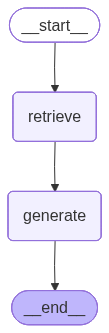

In [13]:
from langgraph.graph import START, StateGraph

# StateGraph 초기화
workflow = StateGraph(State)

# 검색(retrieve)과 생성(generate) 단계를 순차적으로 실행하도록 설정 (node 자동 추가)
workflow.add_sequence([retrieve, generate])

# 그래프의 시작점(START)을 'retrieve' 단계와 연결
workflow.add_edge(START, "retrieve")

# 그래프를 컴파일하여 최종 그래프 객체를 생성
app = workflow.compile()
app

In [14]:
# 그래프를 호출하여 사용자 질문에 대한 답변을 생성
result = app.invoke({"question": "LLM 에이전트의 4가지 유형은 무엇인가요?"})

# 질문
print(f'Question: {result["question"]}\n\n')

# 문서의 출처
print(f'Context: {result["context"][0].metadata}\n\n')

# 생성된 답변(Answer)을 출력
print(f'Answer: {result["answer"]}')

Question: LLM 에이전트의 4가지 유형은 무엇인가요?


Context: {'source': 'https://botpress.com/ko/blog/llm-agents', 'start_index': 2397}


Answer: LLM 에이전트의 4가지 유형은 대화형 상담원, 작업 지향 에이전트, 크리에이티브 에이전트, 협업 에이전트입니다.  
대화형 상담원은 사용자와 자연스러운 대화를 통해 정보를 제공하고 문제를 해결합니다.  
작업 지향 에이전트는 특정 작업 수행에 집중하고, 크리에이티브 에이전트는 창의적 콘텐츠를 제작하며, 협업 에이전트는 인간과의 협업을 촉진합니다.


-----------------
**LangGraph**는 RAG 애플리케이션을 구축하는 데 반드시 필요하지는 않습니다. 실제로 개별 구성 요소를 사용하여 동일한 애플리케이션 로직을 구현할 수도 있습니다. 

In [15]:
# Langgraph 없이 RAG 구현한 경우
question = "LLM 에이전트의 4가지 유형은 무엇인가요?"

# 벡터 스토어에서 질문과 유사한 문서 검색
retrieved_docs = vector_store.similarity_search(question)

# 검색된 문서들의 내용을 하나의 문자열로 결합
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

# 검색된 문서(Context)와 질문을 프롬프트 템플릿에 전달하여 메시지 생성
message = chat_prompt.invoke({"question": question, "context": docs_content}).to_messages()

# LLM(대형 언어 모델)을 호출하여 답변 생성
answer = model.invoke(message)

# 생성된 답변 출력
print(answer.content)

LLM 에이전트의 4가지 유형은 1) 대화형 상담원, 2) 작업 지향 에이전트, 3) 크리에이티브 에이전트, 4) 협업 에이전트입니다.
